# Prepare files for steadiercom

- Ulimited compounds "--unlimited unlimited.txt" - use Daniels input
- Give media file with specific uptake


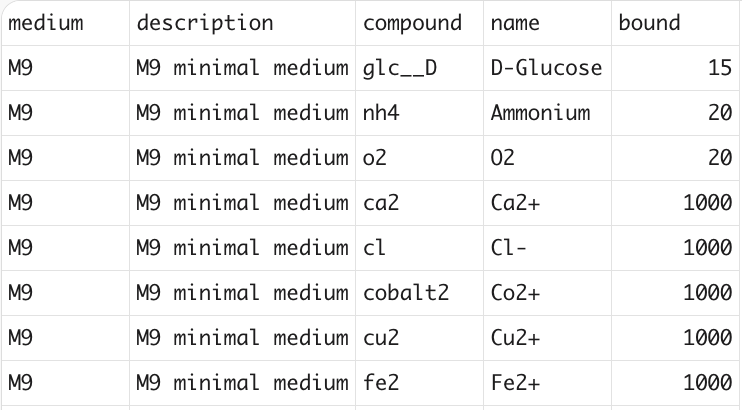

In [1]:
import sys
import pandas as pd
import reframed
import os
import json
import shutil
import copy

sys.path.append('../functions')

import pandas as pd

import general_functions as general_func
import translation_dicts

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
compounds_dict, source_dict,substrate_dict, gas_sheet_dict, community_dict = translation_dicts.translation_dicts()

### Read data

In [4]:
all_mags = general_func.read_allmags_data()

In [5]:
MAG2community_id= pd.read_csv("../output/MAG2community_id.tsv",sep="\t",header=None)

In [6]:
model_uni = reframed.load_cbmodel("../input/universe_bacteria.xml")

## Prepare media files

In [7]:
syncon_dict = {"SC1":"SynCon1",
              "SC2":"SynCon2"}

carb_substrate_dict = {"X":"Xylan",
                       "C":"Cellulose"}

substrate_composition = {"Cellulose":["cellb","cell3","cell4","cell5"], # NB included the monosaccharides here as well
                         "Xylan":["xylb","xyl3","xylan4","xylan8"]} # NB included the monosaccharides here as well

In [8]:
syncon2 = list(pd.read_csv("../input/syncon2media_combined.csv",header=None)[0].values)

syncon1 = copy.copy(syncon2)
syncon1.remove("slnt")
syncon1.append("ascb__L")

**Create separate media and add carbon substrate**

In [9]:
media = {}

for polysaccharide,compounds in substrate_composition.items():
    media["SC1_"+polysaccharide[0]] = copy.copy(syncon1)
    media["SC1_"+polysaccharide[0]].extend(compounds)
    
    media["SC2_"+polysaccharide[0]] = copy.copy(syncon2)
    media["SC2_"+polysaccharide[0]].extend(compounds)

**Create media dataframes for each media**

medium | description | compound | name

In [10]:
media_dfs = []
for media_id,compounds in media.items():
    media_id_list = media_id.split("_")
    
    SC_type=syncon_dict[media_id_list[0]]
    substrate = carb_substrate_dict[media_id_list[1]]
    
    
    # NB! Some of the compounds they used are not in the universal model!
    compounds = [met for met in compounds if "M_"+met+"_e" in model_uni.metabolites]
    compounds_names = [model_uni.metabolites["M_"+met+"_e"].name for met in compounds]
    
    media_df = pd.DataFrame({"medium":[media_id for met in compounds],
               "description": SC_type + " on "+ substrate,
               "compound":compounds,
               "name":compounds_names})
    media_dfs.append(media_df)

media_dfs_all = pd.concat(media_dfs)

### Define bounds for components in media

In [11]:
media = media_dfs_all.copy()

In [12]:
def find_bounds(met):
    
    if met=="glc__D":
        return 1/10
    elif met=="cellb":
        return 1/20
    elif met=="cell3":
        return 1/30
    elif met=="cell4":
        return 1/40
    elif met=="cell5":
        return 1/50
    
    elif met=="xyl__D":
        return 6/50
    elif met=="xylb":
        return 6/100
    elif met=="xyl3":
        return 6/150
    elif met=="xylan4":
        return 6/260
    elif met=="xylan8":
        return 6/520
    
    elif met=="cys__L":
        return 1e-3
    elif met=="ascb__L":
        return 1e-3
    else:
        return 1000
    

In [13]:
media["bound"]=media.compound.map(find_bounds)

In [14]:
media

,medium,description,compound,name,bound
0,SC1_C,SynCon1 on Cellulose,zn2,Zinc,1000.000000
1,SC1_C,SynCon1 on Cellulose,mn2,Manganese,1000.000000
2,SC1_C,SynCon1 on Cellulose,fe3,Iron (Fe3+),1000.000000
3,SC1_C,SynCon1 on Cellulose,k,Potassium,1000.000000
4,SC1_C,SynCon1 on Cellulose,so4,Sulfate,1000.000000
...,...,...,...,...,...
27,SC2_X,SynCon2 on Xylan,thm,Thiamin,1000.000000
28,SC2_X,SynCon2 on Xylan,xylb,Xylobiose,0.060000
29,SC2_X,SynCon2 on Xylan,xyl3,Xylotriose,0.040000
30,SC2_X,SynCon2 on Xylan,xylan4,"Xylan (4 backbone units, 1 glcur side chain)",0.023077


## Prepare MAG-community data 

In [15]:
top_99 = all_mags[all_mags["new_coverage"]>1].index.values

In [16]:
MAG2community_id_99= MAG2community_id[MAG2community_id[0].isin(top_99)]
MAG2community_id_99

,0,1
0,CH13-bin.12,CD_A
1,CH13-bin.11,CD_A
2,CH13-bin.4,CD_A
3,CH13-bin.14,CD_A
4,CH13-bin.25,CD_A
...,...,...
92,CH1-bin.1,M_P
93,CH1-bin.10,M_P
98,CH3-bin.2,M_X
99,CH3-bin.1,M_X


In [17]:
communities_99 = MAG2community_id_99.copy()
communities_99 = communities_99.set_index(1).reset_index().transpose().reset_index(drop=True).transpose()

In [18]:
communities_99_SC2_C = communities_99[communities_99[0].isin(["CM_A","CM_P","M_A","M_P"])].copy()
communities_99_SC1_C = communities_99[communities_99[0].isin(["CD_A","CD_P"])].copy()
communities_99_SC1_X = communities_99[communities_99[0].str.endswith("_X")].copy()

communities_list = [communities_99_SC2_C,communities_99_SC1_C,communities_99_SC1_X]

### Map to relative abundance

In [19]:
mag2coverage = all_mags["new_coverage"].to_dict()

for communities in communities_list:
    communities[2]=communities[1].map(lambda x: mag2coverage[x]/100)

### Save data

In [20]:
MAG2community_id_99.set_index(1).to_csv("../output/steadiercom_sample_0.1.3/communities_top99.tsv",sep="\t",header=None,index_label=None)

communities_99_SC1_C.to_csv("../output/steadiercom_sample_0.1.3/communities_99_SC1_C.tsv",sep="\t",header=None,index_label=None,index=None)
communities_99_SC2_C.to_csv("../output/steadiercom_sample_0.1.3/communities_99_SC2_C.tsv",sep="\t",header=None,index_label=None,index=None)
communities_99_SC1_X.to_csv("../output/steadiercom_sample_0.1.3/communities_99_SC1_X.tsv",sep="\t",header=None,index_label=None,index=None)


In [21]:
media_dfs_all.to_csv("../output/steadiercom_sample_0.1.3/media_db.tsv",sep="\t",index=False)

media.to_csv("../output/steadiercom_sample_0.1.3/media_db_constrained.tsv",sep="\t",index_label=None,index=None)

#### CM_X